In [23]:
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import scipy.signal as signal

#FUNCION DETECTORA DE PICOS

def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array == lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not found!' if if_not_found == '' else if_not_found

    else:
        return match_value.tolist()[0]
    
    
#CARGA DE DATOS
D=50/1000 #Diametro de la parte cilindrica [m]
T=273.15+18
rho=PropsSI('D', 'T',T , 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu=PropsSI('V', 'T', T, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L=0.175*2 #Largo del cilindro en metros
A=D*L ## area proyectada

In [80]:
#LECTURA DE DATOS

VelocityFile = "Velocidades Calibradas/Velocidades.txt"
VelocityData = pd.read_csv(VelocityFile)
PolinomioVelocidad=np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)

RawDataFolder = "Raw Data/"
files = np.sort(glob.glob(RawDataFolder+'*.txt'))
VoltajeMedicion=[]
VelocidadMedicion=[]
ReMedicion=[]
for i in files:
    item=i.strip("Raw Data\\V")
    item=item.strip(".txt")
    item=item.strip("")
    VoltajeMedicion.append(float(item))
    Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
    VelocidadMedicion.append(Vitem)
    ReMedicion.append(Vitem*D*rho/mu)
    
Inicial= {
    "Voltaje" : VoltajeMedicion,
    "Velocidad" : VelocidadMedicion,
    "Re" : ReMedicion,
    }

DFInicial = pd.DataFrame(Inicial)


DFFinal=pd.DataFrame()
#vectorvector=[]
for k in files:
    #Importo los datos y le saco datos de cabeza y de cola
    datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
    datos = datos[:-100]
    datos.columns = ["Time", "Frequency", "Drag", "Lift"]
    datos = datos.astype(float)
    datos=datos[800:2500]
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=(datos["Drag"].mean())
    stdDrag=(datos["Drag"].std())
    df=datos
    
    #Filtro para las cosas MUY gruesas por señales espurias, no se suele activar
    
    for i in df.index:
        if df["Lift"][i]>(mediaLift+200*stdLift):
            df["Lift"][i]=np.nan
        if df["Lift"][i]<(mediaLift-200*stdLift):
            df["Lift"][i]=np.nan
        if df["Drag"][i]>(mediaDrag+200*stdDrag):
            df["Drag"][i]=np.nan
        if df["Drag"][i]<(mediaDrag-200*stdDrag):
            df["Drag"][i]=np.nan
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=datos["Drag"].mean()
    stdDrag=datos["Drag"].std()   
    
    for i in df.index:
        if df["Lift"][i]>(mediaLift+200*stdLift):
            df["Lift"][i]=np.nan
        if df["Lift"][i]<(mediaLift-200*stdLift):
            df["Lift"][i]=np.nan
        if df["Drag"][i]>(mediaDrag+200*stdDrag):
            df["Drag"][i]=np.nan
        if df["Drag"][i]<(mediaDrag-200*stdDrag):
            df["Drag"][i]=np.nan
    mediaLift=datos["Lift"].mean()
    stdLift=datos["Lift"].std()
    mediaDrag=datos["Drag"].mean()
    stdDrag=datos["Drag"].std()
    
    df.interpolate(method ='linear', limit_direction ='backward', inplace=True)
    
    #LS para ver frecuencais
    tiempos=(df["Time"].values)/1000
    tiempos=tiempos-np.min(tiempos)
    fuerzas=df["Drag"].values
    fuerzas=fuerzas-np.mean(fuerzas)
    step=1/83.33
    w=np.linspace(1,2*np.pi*(1/step)*0.5,100000)
    pgram = signal.lombscargle(tiempos,fuerzas,w, normalize=True)
    
    dfLS=pd.DataFrame()
    dfLS["amp"]=pgram
    dfLS["frec"]=w/(2*np.pi)
    dfLS=dfLS.tail(82000)
    #dfLS=dfLS.head(40000)
    AmpDrag=(df["Drag"].max()-df["Drag"].min())/2
    frecpico=xlookup(dfLS["amp"].max(), dfLS["amp"], dfLS["frec"])
      
    vector = pd.DataFrame(np.array([[k],[mediaLift],[mediaDrag],[AmpDrag],[frecpico]]).T)
    DFFinal=pd.concat([DFFinal,vector], axis=0)

DFFinal.rename(columns={0: 'txt', 1: 'mediaLift', 2: 'mediaDrag', 3: 'AmpDrag', 4: 'frecpico'}, inplace=True)
DFFinal.reset_index(inplace=True)

In [81]:
DFInicial

,Voltaje,Velocidad,Re
0,0.0,-0.120047,-396.775958
1,10.0,0.795018,2627.678481
2,12.0,0.978031,3232.569369
3,14.0,1.161044,3837.460256
4,16.0,1.344056,4442.351144
5,18.0,1.527069,5047.242032
6,20.0,1.710082,5652.132919
7,22.0,1.893095,6257.023807
8,24.0,2.076108,6861.914695
9,26.0,2.259121,7466.805582


In [82]:
DFFinal

,index,txt,mediaLift,mediaDrag,AmpDrag,frecpico
0,0,Raw Data\V00.txt,0.0,-204.216305882353,1.2049999999999983,8.162392019335678
1,0,Raw Data\V10.txt,0.0,-203.26300000000043,1.2250000000000085,7.824946124564068
2,0,Raw Data\V12.txt,0.0,-203.13131176470606,1.7750000000000057,14.514095005424188
3,0,Raw Data\V14.txt,0.0,-202.56781764705875,1.6300000000000097,19.140797820945888
4,0,Raw Data\V16.txt,0.0,-202.0784470588235,1.2250000000000085,18.741922661197403
5,0,Raw Data\V18.txt,0.0,-201.5401941176471,1.375,7.6672223361099325
6,0,Raw Data\V20.txt,0.0,-200.7038411764704,2.969999999999999,7.9868205390301545
7,0,Raw Data\V22.txt,0.0,-199.9393588235294,1.710000000000008,7.630281764603569
8,0,Raw Data\V24.txt,0.0,-198.4400529411759,2.0799999999999983,8.292306613509743
9,0,Raw Data\V26.txt,0.0,-197.56902352941202,2.5799999999999983,8.944785022588428


In [83]:
# en calibrationData va el nombre del archivo que 
CDfile = "CD2.txt"
CDData=open(CDfile,"w")
CDData.write('txt,MediaLift,MediaDrag\n');
RawDataFolder = "RefSoporteDrag/"
files = np.sort(glob.glob(RawDataFolder+'*.txt'))
VoltajeMedicion=[]
VelocidadMedicion=[]
ReMedicion=[]
for i in files:
    item=i.strip("RawSoporte\\V")
    item=item.strip(".txt")
    item=item.strip("")
    VoltajeMedicion.append(float(item))
    Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
    VelocidadMedicion.append(Vitem)
    ReMedicion.append(Vitem*D*rho/mu)
    
Inicial= {
    "Voltaje" : VoltajeMedicion,
    "Velocidad" : VelocidadMedicion,
    "Re" : ReMedicion,
    }
DFInicial2 = pd.DataFrame(Inicial)

for k in files:
    datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
    datos = datos[:-100]
    datos.columns = ["Time2", "Frequency2", "Drag2", "Lift2"]
    datos = datos.astype(float)
    datos=datos[800:3000]
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=(datos["Drag2"].mean())
    stdDrag=(datos["Drag2"].std())
    df=datos
    
    for i in df.index:
        if df["Lift2"][i]>(mediaLift+200*stdLift):
            df["Lift2"][i]=np.nan
        if df["Lift2"][i]<(mediaLift-200*stdLift):
            df["Lift2"][i]=np.nan
        if df["Drag2"][i]>(mediaDrag+200*stdDrag):
            df["Drag2"][i]=np.nan
        if df["Drag2"][i]<(mediaDrag-4*stdDrag):
            df["Drag2"][i]=np.nan
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=datos["Drag2"].mean()
    stdDrag=datos["Drag2"].std()   
    
    for i in df.index:
        if df["Lift2"][i]>(mediaLift+200*stdLift):
            df["Lift2"][i]=np.nan
        if df["Lift2"][i]<(mediaLift-200*stdLift):
            df["Lift2"][i]=np.nan
        if df["Drag2"][i]>(mediaDrag+200*stdDrag):
            df["Drag2"][i]=np.nan
        if df["Drag2"][i]<(mediaDrag-200*stdDrag):
            df["Drag2"][i]=np.nan
    mediaLift=datos["Lift2"].mean()
    stdLift=datos["Lift2"].std()
    mediaDrag=datos["Drag2"].mean()
    stdDrag=datos["Drag2"].std()   
    
    #fig, axes = plt.subplots(nrows=1, ncols=2)
    #fig.set_size_inches(15, 5)
    #df.plot.scatter(ax=axes[0],x="Time2", y="Lift2")
    #df.plot.scatter(ax=axes[1],x="Time2", y="Drag2")
    #fig.savefig(k+".png", dpi=100)
    
    # Las lineas vienen como #.txt,mediaL,mediaD,stdL,stdD
    #CDData.write(i+","+str(mediaLift)+","+str(mediaDrag)+","+str(stdLift)+","+str(stdDrag)+"\n")
    CDData.write(str(k)+","+str(mediaLift)+","+str(mediaDrag)+"\n")
    print(k)
    
CDData.close()
DFFinal2=pd.read_csv(CDfile)


In [84]:
DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
DatosCD2=pd.concat([DFFinal2,DFInicial2],axis =1)

In [6]:
## Tomo la referencia y la borro del original


Referencia=DatosCD[:1]
Drag0=Referencia["MediaDrag"][0]
Lift0=Referencia["MediaLift"][0]
DatosCD=DatosCD.drop([0]) 


Referencia2=DatosCD2[:1]
Drag02=Referencia2["MediaDrag"][0]
Lift02=Referencia2["MediaLift"][0]
DatosCD2=DatosCD2.drop([0]) 

### Uso la referencia para poner en 0 todo
DatosCD["Drag"]= DatosCD["MediaDrag"]-Drag0
DatosCD["Lift"]= DatosCD["MediaLift"]-Lift0

DatosCD2["Drag"]= DatosCD2["MediaDrag"]-Drag02
DatosCD2["Lift"]= DatosCD2["MediaLift"]-Lift02

DatosCD["Drag"]= DatosCD["Drag"]-DatosCD2["Drag"]
DatosCD["Lift"]= DatosCD["Lift"]-DatosCD2["Lift"]
DatosCD["St"]=D*DatosCD["PicoDrag"]/DatosCD["Velocidad"]
DatosCD["AmpDrag"]=DatosCD["AmpDrag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])

#limpio los datos que ya no me sirven

DatosCD=DatosCD.drop("txt", axis=1)
DatosCD=DatosCD.drop("MediaDrag", axis=1)
DatosCD=DatosCD.drop("MediaLift", axis=1)

In [7]:
DatosCD["CD"]=DatosCD["Drag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])
DatosCD["CL"]=DatosCD["Lift"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])

In [8]:
DatosCD

,AmpDrag,PicoDrag,Voltaje,Velocidad,Re,Drag,Lift,St,CD,CL
1,1.814673,7.824946,10.0,0.795018,2627.678481,2.073233,0.0,0.492124,3.071216,0.0
2,1.737438,14.514095,12.0,0.978031,3232.569369,2.635576,0.0,0.742006,2.579803,0.0
3,1.132156,19.140798,14.0,1.161044,3837.460256,2.857029,0.0,0.824293,1.984420,0.0
4,0.634917,18.741923,16.0,1.344056,4442.351144,3.127672,0.0,0.697215,1.621071,0.0
5,0.552079,7.667222,18.0,1.527069,5047.242032,3.533353,0.0,0.251044,1.418683,0.0
6,0.950908,7.986821,20.0,1.710082,5652.132919,4.045178,0.0,0.233522,1.295149,0.0
7,0.446753,7.630282,22.0,1.893095,6257.023807,4.713956,0.0,0.201529,1.231563,0.0
8,0.451834,8.292307,24.0,2.076108,6861.914695,6.006730,0.0,0.199708,1.304831,0.0
9,0.473322,8.944785,26.0,2.259121,7466.805582,6.484578,0.0,0.197970,1.189648,0.0
10,0.319478,9.642090,28.0,2.442134,8071.696470,7.590774,0.0,0.197411,1.191689,0.0


<ErrorbarContainer object of 3 artists>

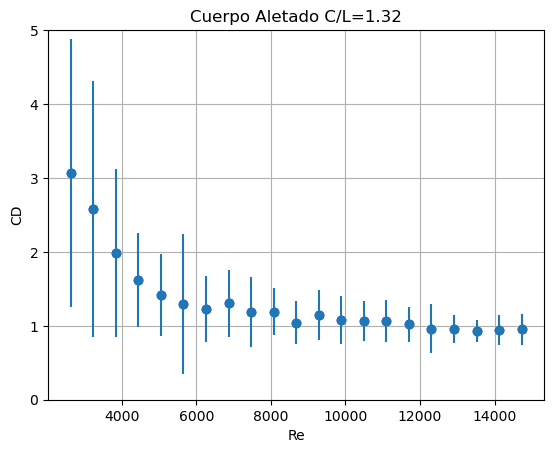

In [15]:
tit="Cuerpo Aletado C/L=1.32"
#DatosCD.plot.scatter(x="Re", y="CD")
a=DatosCD["Re"].values
b=DatosCD["CD"].values
c=DatosCD["St"].values

#d=(DatosCD["PicoDrag"]).values
#e=DatosCD["F Strouhal"].values
plt.scatter(a, b, color="blue")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(DatosCD["AmpDrag"]).values, fmt="o")


(0.0, 1.0)

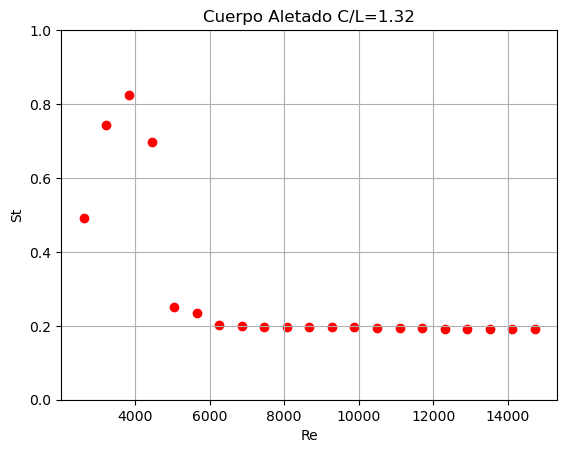

In [18]:
plt.scatter(a, c, color="red",)
#plt.scatter(a, e, color="green", label="Valor de Strouhal")
plt.xlabel("Re")
plt.ylabel("St")
plt.title(tit)
plt.ylim(bottom=0)
plt.grid()
plt.ylim(top=1)


